# Rust Export

Author: Jan

The goal of this notebook is to take the raw data download from crates.io and export into a nice single file for use with networkx later by other team members.


In [146]:
import os
import pandas as pd
from tqdm import tqdm
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set_theme(style="whitegrid")

In [4]:
data_path = "../data/rust-raw/data"

In [115]:
crates = pd.read_csv(os.path.join(data_path, "crates.csv"))
dependencies = pd.read_csv(os.path.join(data_path, "dependencies.csv"))
versions = pd.read_csv(os.path.join(data_path, "versions.csv"))
download = pd.read_csv(os.path.join(data_path, "crate_downloads.csv"))

print("Number of crates: ", len(crates))
print(crates.columns)

print("Number of dependencies: ", len(dependencies))
print(dependencies.columns)

print("Number of versions: ", len(versions))
print(versions.columns)

print("Number of downloads: ", len(download))
print(download.columns)

Number of crates:  145269
Index(['created_at', 'description', 'documentation', 'homepage', 'id',
       'max_features', 'max_upload_size', 'name', 'readme', 'repository',
       'updated_at'],
      dtype='object')
Number of dependencies:  10351159
Index(['crate_id', 'default_features', 'explicit_name', 'features', 'id',
       'kind', 'optional', 'req', 'target', 'version_id'],
      dtype='object')
Number of versions:  1122075
Index(['checksum', 'crate_id', 'crate_size', 'created_at', 'downloads',
       'features', 'id', 'license', 'links', 'num', 'published_by',
       'rust_version', 'updated_at', 'yanked'],
      dtype='object')
Number of downloads:  145269
Index(['crate_id', 'downloads'], dtype='object')


In [116]:
G = nx.DiGraph()

# First get all nodes
for i, row in tqdm(
    crates[["id", "created_at", "name", "repository"]].iterrows(),
    total=len(crates),
    desc="Adding nodes",
):
    crate_id, created_at, name, repository = row
    num_of_downloads = download[download["crate_id"] == crate_id]["downloads"].values[0]

    G.add_node(
        crate_id,
        name=name,
        repository=repository,
        created_at=created_at,
        downloads=str(num_of_downloads),
    )

Adding nodes: 100%|██████████| 145269/145269 [00:16<00:00, 8556.73it/s]


In [117]:
# Group version by crate_id and get the latest version
latest_versions = versions.groupby("crate_id").apply(
    lambda x: x.sort_values("id", ascending=False).iloc[0]
)

latest_versions.head()

,checksum,crate_id,crate_size,created_at,downloads,features,id,license,links,num,published_by,rust_version,updated_at,yanked
crate_id,,,,,,,,,,,,,,
6,b16afcea1f22891c49a00c751c7b63b2233284064f11a2...,6,51844.0,2023-08-07 18:51:10.671183,10126732,"{""default"": [""xattr""]}",866039,MIT/Apache-2.0,NaN,0.4.40,1.0,NaN,2023-08-07 18:51:10.671183,f
7,61697e0a1c7e512e84a621326239844a24d8207b4669b4...,7,30622.0,2024-05-07 02:16:24.444335,90703,"{""std"": [], ""default"": [""std""]}",1136648,MIT OR Apache-2.0,NaN,1.0.23,3618.0,1.31,2024-05-07 02:16:24.444335,f
8,d2fabcfbdc87f4758337ca535fb41a6d701b65693ce382...,8,18880.0,2023-01-06 14:36:38.757028,51284660,{},697402,MIT OR Apache-2.0,NaN,0.3.1,55123.0,NaN,2023-01-06 14:36:38.757028,f
9,3135b08af27d103b0a51f2ae0f8632117b7b185ccf9314...,9,9557.0,2024-04-12 22:51:05.282676,438553,"{""std"": [""num-bigint/std"", ""num-complex/std"", ...",1113849,MIT OR Apache-2.0,NaN,0.4.2,539.0,NaN,2024-04-12 22:51:05.282676,f
10,a183cf7feeba97b4dd1c0d46788634f6221d87fa961b30...,10,44043.0,2024-03-19 00:20:38.05886,4186341,"{""js"": [""dep:wasm-bindgen"", ""getrandom?/js""], ...",1087457,Apache-2.0 OR MIT,NaN,1.8.0,3204.0,1.60.0,2024-03-19 00:20:38.05886,f


In [118]:
for crate_id in tqdm(
    crates["id"].values,
    total=len(crates),
    desc="Adding edges",
):
    latest_version = latest_versions[latest_versions["crate_id"] == crate_id].iloc[0]

    # We the latest version, we can get the dependencies (of the latest version of the crate)
    deps = dependencies[dependencies["version_id"] == latest_version["id"]]

    for j, dep_id in deps[["crate_id"]].itertuples():
        # Add edge from the crate to its dependency
        G.add_edge(crate_id, dep_id)

        # Get the dependency name
        # dep_name = crates[crates["id"] == dep_id]["name"].values[0]
        # print(f"{j}: {name} has a dep {dep_name} with id {dep_id}")

Adding edges: 100%|██████████| 145269/145269 [09:51<00:00, 245.60it/s]


In [119]:
nx.write_pajek(G, "crates_io.net")

In [137]:
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("Number of connected components: ", nx.number_weakly_connected_components(G))

Number of nodes:  145269
Number of edges:  830376
Number of connected components:  25179


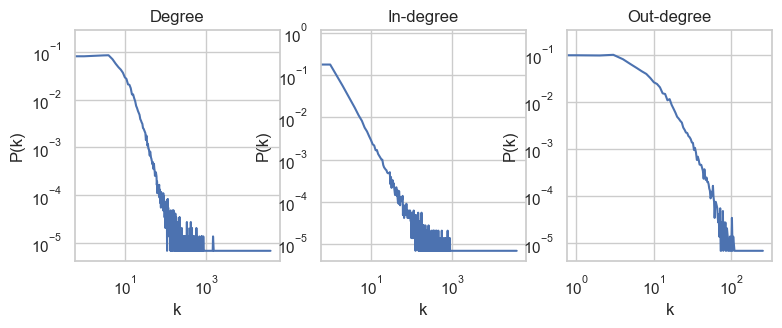

In [148]:
def get_k_distribution(G, fn):
    n = len(G)
    return {k: v / n for k, v in Counter([k for _, k in fn(G)]).items()}


ks = {
    "Degree": get_k_distribution(G, lambda g: g.degree()),
    "In-degree": get_k_distribution(G, lambda g: g.in_degree()),
    "Out-degree": get_k_distribution(G, lambda g: g.out_degree()),
}

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for i, (k, dist) in enumerate(ks.items()):
    sns.lineplot(x=list(dist.keys()), y=list(dist.values()), ax=axs[i])

    axs[i].set_title(k)
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlabel("k")
    axs[i].set_ylabel("P(k)")

plt.show()